# Fitting shape models

#### Marcel Lüthi, Departement of Mathematics and Computer Science, University of Basel 


In this notebook we are fitting our model to a given contour and thereby obtain a distribution over 3D shapes. This distribution can be used to obtain statistically meansingful reconstructions of the 3D shape from the data, as well as the associated uncertainty. 

As always, we are starting with fitting simulated data, for which we know the ground truth. This allows us to check if the computational procedure works, before we assess the quality of our model on real data. 

### Setup

We begin as usual with setting up the kernel and importing all the necessary libraries. 

In [5]:
// Suppressing excessive output for the jupyter-notebook
val api = implicitly[almond.api.JupyterApi]
api.silent(true)

In [6]:
// add repositories from which libraries are loaded. 
import coursierapi.{Credentials, MavenRepository}
interp.repositories() ++= Seq(
  MavenRepository.of("https://oss.sonatype.org/content/repositories/snapshots")
)

In [7]:
// downloading the libraries
import $ivy.`ch.unibas.cs.gravis::scalismo-plot:0.1-SNAPSHOT`
import $ivy.`ch.unibas.cs.gravis::scalismo-renderer:0.1-SNAPSHOT`
import $ivy.`org.scalanlp::breeze:2.1.0`
import $ivy.`org.scalanlp::breeze-natives:2.1.0`

In [8]:
// imports

// scalismo imports
import scalismo.io.StatisticalModelIO
import scalismo.io.LandmarkIO
import scalismo.geometry.*
import scalismo.common.*
import scalismo.statisticalmodel.*
import scalismo.mesh.{TriangleMesh, LineMesh}
import scalismo.transformations.*

// sampling framework
import scalismo.sampling._
import scalismo.sampling.proposals._
import scalismo.sampling.parameters._
import scalismo.sampling.evaluators._
import scalismo.sampling.loggers.MHSampleLogger
import scalismo.sampling.algorithms.MetropolisHastings


// rendering
import scalismo.renderer.{ContourRenderer, Renderer, show}
import scalismo.color.RGB

// plotting
import scalismo.plot.data.DataFrame
import scalismo.plot.plottarget.PlotTarget.plotTargetJupyter

// linear algebra and statistics
import breeze.linalg.DenseVector
import breeze.linalg.DenseMatrix
import breeze.stats.distributions.{Gaussian, MultivariateGaussian}
import breeze.stats.distributions.Rand.FixedSeed.randBasis

// java helpers
import java.io.File

We also define the random number generator.

In [9]:
given rng: scalismo.utils.Random = scalismo.utils.Random(42)

### Generating simulated data

In the last notebook, we have written a function to generate data. We use the same function here, but do not choose a random sample from the prior but one that we control:

In [11]:
def generate(vertebraModel : PointDistributionModel[_3D, TriangleMesh], shapeCoefficients : DenseVector[Double], sensorDistance : Int, sourceLocation : Point[_3D], noiseSigma : Double) : LineMesh[_2D] = 
    
    // sample from the prior    
    val sample = vertebraModel.instance(shapeCoefficients)

    // project the sampled shape to get the contour
    val sampledContour = ContourRenderer.projectMeshContours(sample, sensorDistance, sourceLocation)
    
    if noiseSigma > 1e-5 then     
        // add Gaussian noise to each point  
        val noiseTransform = Transformation2D( (point : Point[_2D]) => 
            val pointVec = DenseVector(point.x, point.y)
            val noisyPoint = MultivariateGaussian(pointVec, DenseMatrix.eye[Double](2)* noiseSigma).draw()

            Point2D(noisyPoint(0), noisyPoint(1))
        )                 
        sampledContour.transform(noiseTransform)
    else sampledContour

We can use this procedure to generate "fake" data to which we fit our model:

In [12]:
val vertebraModel = StatisticalModelIO.readStatisticalTriangleMeshModel3D(File("./data/vertebra-model.h5")).get


val coeffs = DenseVector.zeros[Double](vertebraModel.rank)
coeffs(0) = -3
coeffs(1) = 1.0
coeffs(2) = 1.5
val sensorDistance = 100
val sourceLocation = Point3D(0, 0, 50)
val noiseSigma : Double = 1.0

val targetContour = generate(vertebraModel, coeffs, sensorDistance, sourceLocation, noiseSigma)

Our target contour looks as follows:

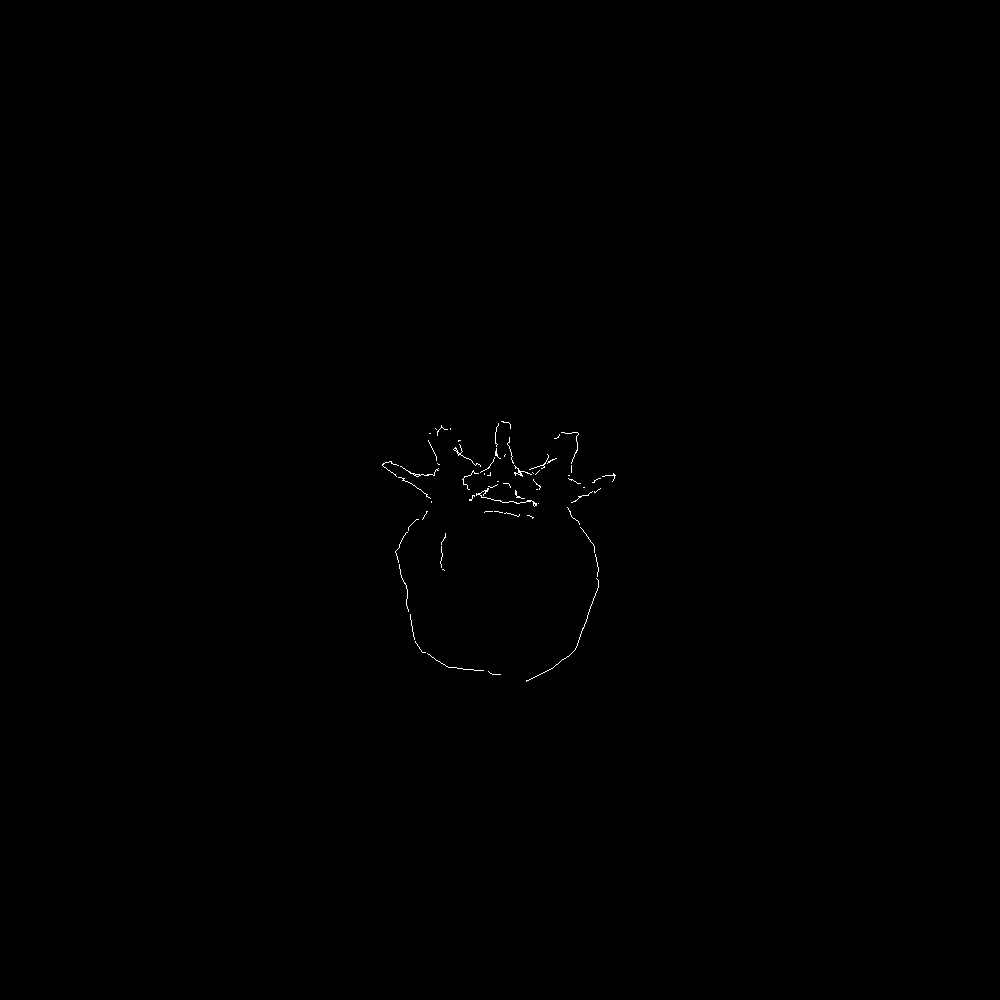

In [9]:
ContourRenderer.renderMeshContour(targetContour, 1000, 1000).show()

### Setting up the markov chain

We can now set up the Markov-Chain to sample from the posterior, exactly as we did it for the regression example:

#### Evaluators

We start with defining evaluators for the priors and the likelihood function. Note that we use the class `ShapeParameters`, instead of defining our own parameter vector. It is essentially defined as 

```scala 
case class ShapeParameters(coefficients : DenseVector[Double])
``` 
but adds some convenience functions that make it easier to work with the Scalismo sampling code. 

The definition of the prior is straight-forward:

In [13]:
// Prior over the shape parameters.  
case class PriorEvaluator(model: PointDistributionModel[_3D, TriangleMesh])
      extends MHDistributionEvaluator[ShapeParameters] {
          
    val shapeParameterPrior = MultivariateGaussian(DenseVector.zeros[Double](model.rank), DenseMatrix.eye[Double](model.rank))
          
    override def logValue(sample: MHSample[ShapeParameters]): Double = {
        shapeParameterPrior.logPdf(sample.parameters.coefficients) 
    }
  }

The likelihood function is a bit more involved. What is happening is that we generate a contour using the current parameters, and compare that contour to the target contour. The assumption is, that every point of the generated contour explains the closest point on the target contour up to Gaussian noise. 

In [16]:
// Likelihood
case class ContourEvaluator(
        model: PointDistributionModel[_3D, TriangleMesh],
        targetContour: LineMesh[_2D], 
        sensorDistance : Int, 
        sourceLocation : Point[_3D], 
        noiseSigma : Double
    ) extends MHDistributionEvaluator[ShapeParameters]:

    def pointToBreezeVector(p : Point[_2D]) : DenseVector[Double] = 
        DenseVector[Double](p.x, p.y)
    
    override def logValue(sample: MHSample[ShapeParameters]): Double = 

        // generate the contour corresponding to the model coefficients given in the parameters
        val modelInstance : TriangleMesh[_3D] = model.instance(sample.parameters.coefficients) 
        val sampledContour : LineMesh[_2D] = ContourRenderer.projectMeshContours(modelInstance, sensorDistance, sourceLocation)                
    
        // compare the generated contour to the target contour that we want to explain and compute the likelihood
        // the comparison is done point wise, and the assumption is that the observations are independent
        val likelihoods = for contourPoint <- sampledContour.pointSet.points yield            
            val likelihoodDist = MultivariateGaussian(pointToBreezeVector(contourPoint), DenseMatrix.eye[Double](2) * noiseSigma)            
            val closestTargetPoint = targetContour.pointSet.findClosestPoint(contourPoint).point            
            likelihoodDist.logPdf(pointToBreezeVector(closestTargetPoint))
        likelihoods.sum    

Using the prior and the likelihood evaluator, we can define the posterior. 

In [17]:
val likelihoodEvaluator = ContourEvaluator(vertebraModel, targetContour, sensorDistance, sourceLocation, noiseSigma).cached
val priorEvaluator = PriorEvaluator(vertebraModel).cached
val posteriorEvaluator = ProductEvaluator(likelihoodEvaluator, priorEvaluator)

#### Proposals

Next we define the proposals for the Metropolis-Hastings algorithm. We use here a single proposal, which randomly perturbes the shape parameters:

In [20]:
val shapeProposal =
    GaussianRandomWalkProposal(0.05, "shape").forType[ShapeParameters]

#### Putting it together

We can now put everything together:

In [22]:
val logger = MHSampleLogger[ShapeParameters]()
val chain = MetropolisHastings(shapeProposal, posteriorEvaluator)

val initialParameters = ShapeParameters(DenseVector.zeros[Double](vertebraModel.rank))
val mhIterator = chain.iterator(MHSample(initialParameters, "inital"), logger)

Let's draw some samples from the posterior:

In [25]:
val samples = mhIterator.drop(100).take(1000).toIndexedSeq

The most likely reconstruction is given by the sample with the highest posterior value

In [26]:
val bestSample = samples.maxBy(posteriorEvaluator.logValue)

Printing the coefficients reveals, that they are close to our ground truth. 

In [27]:
println(bestSample)

MHSample(ShapeParameters(DenseVector(-2.824928121342954, 1.0395133823164144, 0.9702859035285134, 0.2474685910531159, 0.0011142281365626727, 0.469345695598467, -0.08361953734776321, -0.25942805633278526, 0.4287474561833364, 0.4172904679179833, 0.6114515857459055, 0.2180862014578882, -0.47490628059755857, -0.47768045696142314, 0.0020913565010944254, -0.2651164921792562, -0.17154290433459318, -0.5868464345816984, -0.039037024970727835, -0.2872004489440352, 0.06843408843531056, 0.24427189129242396, 0.5764990493338008, 0.4201962076275793, -0.585166330735634, 0.2863764753529139, 0.5057905567716734, 0.11312186597718937, -1.06665708769877, 0.19135765803581622, 0.5547464903318139, -0.44625553780096755, 0.6299701196620551, 0.08953541565025835, 0.49330080872983456, -0.18511404740137075, 0.3614544624513736, -0.3710942480589279, 0.2175230311425569, -0.7389433282543435, -0.5205907144948667, -0.05657212174602248, 0.9431530606941344, -0.3761637263782481, 0.5434242800426432, 0.7373567909704412, -0.7772

Let's visually compare the two:

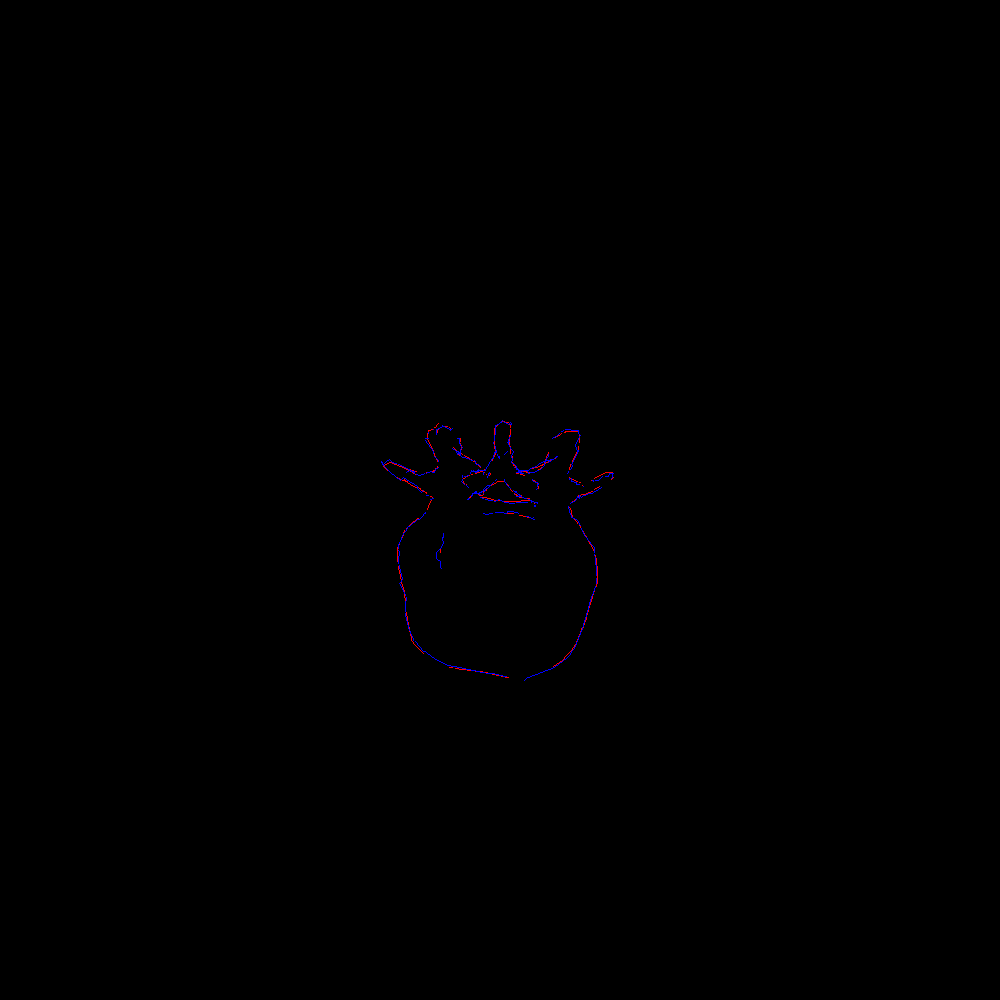

In [31]:
val bestMesh = vertebraModel.instance(bestSample.parameters.coefficients)
val bestConour = ContourRenderer.projectMeshContours(bestMesh, sensorDistance, sourceLocation)
ContourRenderer.renderMeshContours(Seq((bestConour, RGB(1.0, 0, 0)), (targetContour, RGB(0, 0, 1.0))), 1000, 1000).show()

As we see, the two contours are really close together. Let's see how the reconstruction looks like:

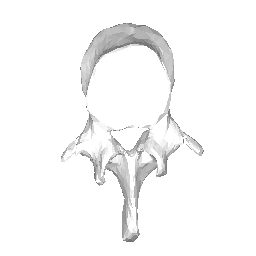

In [32]:
def render(mesh : TriangleMesh[_3D]) : Unit = 
    Renderer.renderMesh(mesh, RGB.White, Point3D(0, 0, 250), 256, 256).show()
render(bestMesh)


An important point is, however, that we do not only have a single, best reconstruction. Since the contour represents only a part of shape, we expect that there is some uncertainty regarding the true shape. The simplest way to get a feeling for how much uncertainty is in the 3D reconstruction, is to look at different 3D reconstructions visually in a 3D viewer. 
Another possibility is to obtain measurements, such as the surface area or the volume from the 3D reconstructions and plot the differences. This is illustrated below:

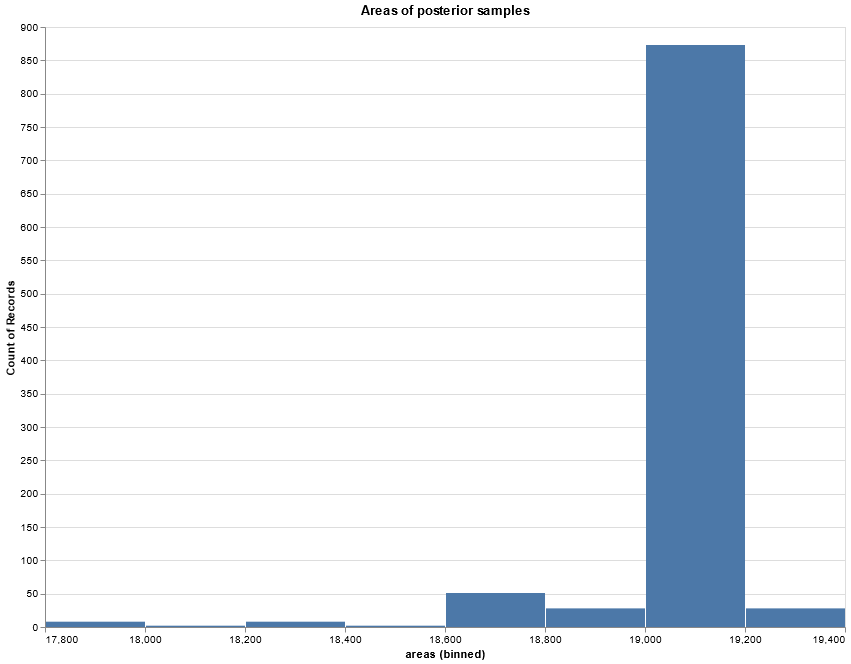

In [38]:
val areas = for sample <- samples yield 
    val mesh = vertebraModel.instance(sample.parameters.coefficients)
    mesh.area

DataFrame(Seq(
    DataFrame.Column.ofContinuous(areas, "areas")) 
)
.plot.histogram("areas", "Areas of posterior samples").show()

#### Exercises

* Visualize some other samples from the posterior distribution. Do they look different or very similar? How well do they represent the target?
* Create pair-plots of the first 4 coefficients, as we did for the toy problem. What do you observe?
* How does the noise you choose affect the solution accuracy and the uncertainty?
* Try different parameters for the ground truth. Does the computational procedure also work for these parameters?
    * You will need to add additional proposals for these parameters. Think carefully about their scale and how large you should do the steps in the random walk
* The scenario outlined here only fits the shape coefficients and assumes that pose, sensor distance and other parameters are fixed. Make it more realistic, by adding more parameters. Use [this notebook](https://github.com/shape-the-world/big-data-africa-23/blob/main/notebooks/shape-fitting-full.ipynb), which includes pose, as a starting point. 
